### Classificando problemas ortopédicos

Esse dataset contém dados sobre problemas ortopédicos na coluna vertebral, diagnosticados no Centre Médico-Chirurgical de Réadaptation des Massues, em Lyon, France. Contém 6 atributos biomecânicos para 310 entradas anonimizadas, sendo 100 de pacientes considerados sem problemas (Normal - NO), 60 de pacientes com Hérnia de Disco (Disk Hernia - DH) e 150 de pacientes com Espondilolistese (Spondylolisthesis - SL).

#### Importando as bibliotecas

In [30]:
from sklearn.datasets import fetch_openml
import pandas as pd                       
import matplotlib.pyplot as plt           
import seaborn as sns                    
import numpy as np                        

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score, f1_score
from sklearn.metrics import classification_report, cohen_kappa_score                      
from sklearn.preprocessing import StandardScaler, MinMaxScaler   

#### Carregando a base de dados

In [2]:
dados = fetch_openml(data_id=1523)

In [3]:
df_dados = pd.DataFrame(data=dados['data'])

In [4]:
df_dados.head(2)

,V1,V2,V3,V4,V5,V6
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259


#### Transformando a base de dados

In [5]:
classes = {'1' : 'Disk Hernia',
           '2' : 'Normal',
           '3' : 'Spondylolisthesis'}

In [6]:
df_dados['diagnostic'] = [classes[target] for target in dados.target]

In [7]:
df_dados.head(2)

,V1,V2,V3,V4,V5,V6,diagnostic
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Disk Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Disk Hernia


#### Analise exploratória dos dados

In [8]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   V1          310 non-null    float64
 1   V2          310 non-null    float64
 2   V3          310 non-null    float64
 3   V4          310 non-null    float64
 4   V5          310 non-null    float64
 5   V6          310 non-null    float64
 6   diagnostic  310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [9]:
df_dados.describe()

,V1,V2,V3,V4,V5,V6
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767933
75%,72.877696,22.120395,63.000000,52.695889,125.467675,41.287352
max,129.834041,49.431864,125.742386,121.429566,163.071041,418.543082


Como esta a média dos dados:

In [10]:
df_dados.groupby('diagnostic').mean().reset_index()

,diagnostic,V1,V2,V3,V4,V5,V6
0,Disk Hernia,47.638407,17.398795,35.463524,30.239612,116.474968,2.480251
1,Normal,51.685244,12.821414,43.542605,38.863830,123.890834,2.186572
2,Spondylolisthesis,71.514224,20.748038,64.110108,50.766186,114.518810,51.896687


#### Removendo outlier

In [11]:
df_dados.drop(df_dados.loc[df_dados['V6'] > 400].index, inplace=True)

In [12]:
df_dados[df_dados['V6'] > 400]

,V1,V2,V3,V4,V5,V6,diagnostic


#### Separando os dados em treino e teste

In [13]:
x = df_dados.drop('diagnostic', axis=1)
y = df_dados['diagnostic']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#### Normalizando os dados

In [15]:
scaler = MinMaxScaler()

scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#### Criação do modelo

##### Treinando o modelo com dados escalonados

In [16]:
model_kn = KNeighborsClassifier(n_neighbors=3)

model_kn.fit(x_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [17]:
# predição sem escalonamento
y_pred = model_kn.predict(x_test_scaled)

In [18]:
df_dados.groupby('diagnostic').count()

,V1,V2,V3,V4,V5,V6
diagnostic,,,,,,
Disk Hernia,60,60,60,60,60,60
Normal,100,100,100,100,100,100
Spondylolisthesis,149,149,149,149,149,149


##### Validação do modelo

<Figure size 1500x500 with 0 Axes>

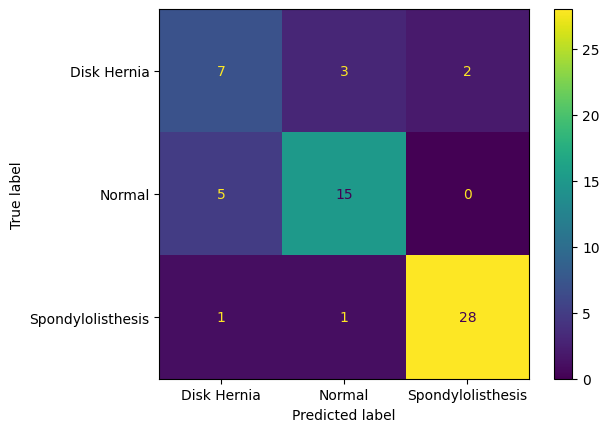

In [23]:
matriz_confusao = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=['Disk Hernia', 'Normal', 'Spondylolisthesis'])

# plotando uma figura com a matriz de confusao
figure = plt.figure(figsize=(15, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=['Disk Hernia', 'Normal', 'Spondylolisthesis'])

disp.plot(values_format='d')

In [24]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

      Disk Hernia       0.54      0.58      0.56        12
           Normal       0.79      0.75      0.77        20
Spondylolisthesis       0.93      0.93      0.93        30

         accuracy                           0.81        62
        macro avg       0.75      0.76      0.75        62
     weighted avg       0.81      0.81      0.81        62



##### Testando o KNN com validação cruzada:

Validação do modelo

In [26]:
kfold = KFold(n_splits=5, shuffle=True)
result = cross_val_score(model_kn, x, y, cv=kfold)

print(f'K-Fold (R^2) Scores: {result}')
print(f'Mean R^2 for Cross-Validation K-Fold: {result.mean()}')

K-Fold (R^2) Scores: [0.82258065 0.80645161 0.91935484 0.72580645 0.83606557]
Mean R^2 for Cross-Validation K-Fold: 0.8220518244315178


In [27]:
error = []

# calculando erro para valores k entre 1 e 15
for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_scaled, y_train)
    pred_i = knn.predict(x_test_scaled)
    error.append(np.mean(pred_i != y_test))

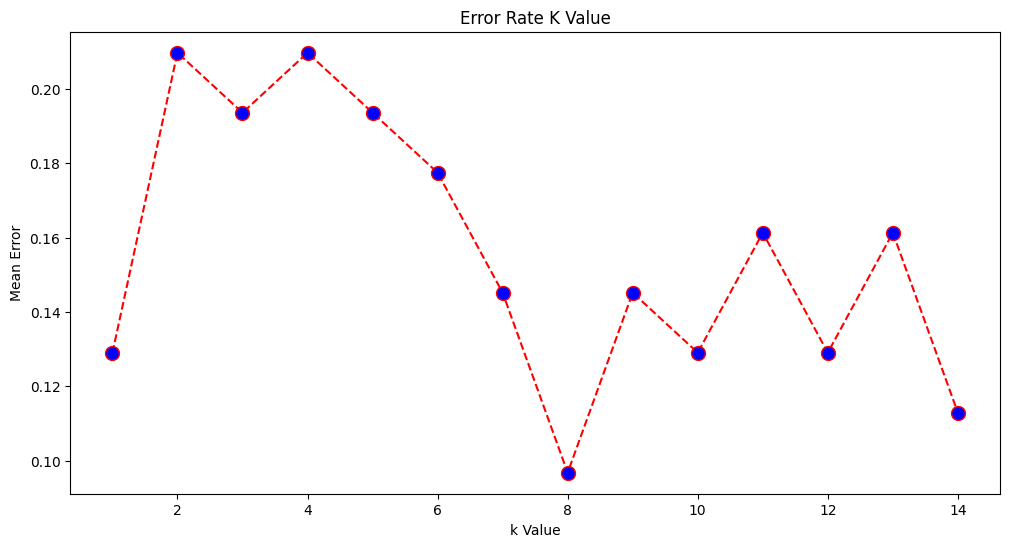

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('k Value')
plt.ylabel('Mean Error')
plt.show()

In [32]:
# Buscar os melhores parâmetros
# Vamos usar uma técnica chamada Gridsearch que é basicamente a busca por força bruta
# Iremos utilizar a técnica de validação cruzada de 5 folds (divisões) em cima do conjunto de treinamento
# Como métrica de melhor desemepnho usaremos a acurácia, isto é, estamos buscando os hiperparâmetros que maximizam a acurácia

# Parâmetros testados
param_grid = {'n_neighbors' : [8,14],
              'weights' : ['uniform', 'distance'],
              'metric' : ['cosine', 'euclidean', 'manhattan']
              }

# métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid=param_grid,
                    scoring=gs_metric,
                    cv=5, n_jobs=4, verbose=3)

grid.fit(x_train_scaled, y_train)
knn_params = grid.best_params_
print('KNN', knn_params)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}


In [33]:
grid.cv_results_

{'mean_fit_time': array([0.00092616, 0.00087509, 0.00090485, 0.00103488, 0.00140295,
        0.00109944, 0.00120697, 0.0007041 , 0.00121913, 0.00130382,
        0.00130382, 0.0011899 ]),
 'std_fit_time': array([0.00014944, 0.00045549, 0.00049351, 0.00086049, 0.00037623,
        0.00020309, 0.00028263, 0.00060495, 0.00039076, 0.00025009,
        0.00039849, 0.0004221 ]),
 'mean_score_time': array([0.00573997, 0.00226345, 0.00696187, 0.00220628, 0.00461302,
        0.00130224, 0.00457778, 0.00181136, 0.00411549, 0.00130644,
        0.00440736, 0.00140581]),
 'std_score_time': array([0.00070086, 0.00076558, 0.00500224, 0.00039802, 0.00097283,
        0.00040075, 0.00089417, 0.00040698, 0.0011692 , 0.0006801 ,
        0.00101824, 0.00049049]),
 'param_metric': masked_array(data=['cosine', 'cosine', 'cosine', 'cosine', 'euclidean',
                    'euclidean', 'euclidean', 'euclidean', 'manhattan',
                    'manhattan', 'manhattan', 'manhattan'],
              mask=[False, Fa

##### Testando vários tipo de algoritmos de classificação

In [36]:
def AplicaValidacaoCruzada(x_axis, y_axis):
    # models
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC

    # cross-validation models
    from sklearn.model_selection import cross_val_score, KFold

    # config kfold
    kfold = KFold(n_splits=10, shuffle=True)

    # axis
    x = x_axis
    y = y_axis

    #criando os modelos

    # KNN
    knn = KNeighborsClassifier(n_neighbors=8, metric='euclidean', weights='distance')
    knn.fit(x_train_scaled, y_train)

    # SVM
    svm = SVC()
    svm.fit(x_train_scaled, y_train)

    # random forest
    rf = RandomForestClassifier(random_state=7)
    rf.fit(x_train_scaled, y_train)

    # Aplica o KFold aos modelos
    knn_result = cross_val_score(knn, x, y, cv = kfold)
    svm_result = cross_val_score(svm, x, y, cv=kfold)
    rf_result = cross_val_score(rf, x, y, cv=kfold)

    # dicionário para armazenar modelos lineares 
    dict_models = {
        'KNN' : knn_result.mean(),
        'SVM' : svm_result.mean(),
        'rf' : rf_result.mean()
    }

    # selecionado o melhor modelo
    best_model = max(dict_models, key=dict_models.get)

    print(f'KNN (R^2): {knn_result.mean()}\nSVM (R^2): {svm_result.mean()}\nRandom Forest (R^2): {rf_result.mean()}')
    print(f'O melhor modelo é: {best_model} com o valor de {dict_models[best_model]}')

In [37]:
AplicaValidacaoCruzada(x, y)

KNN (R^2): 0.831505376344086
SVM (R^2): 0.8578494623655913
Random Forest (R^2): 0.835268817204301
O melhor modelo é: SVM com o valor de 0.8578494623655913
